# MultiVisit Analysis of five eclipses of WASP-189b

We have analysed five visits of WASP-189 individually -- now we will use `pycheops.MultiVisit` to analyse both of the visits simultaneously.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from dace.cheops import Cheops
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import lmfit as lmf
import re
from pycheops.utils import phaser
from pycheops.constants import c, au

Let's load the saved datasets using `MultiVisit` class.

In [2]:
M = pycheops.MultiVisit('WASP-189', ident='none')


 N  file_key                   Aperture last_ GP  Glint pipe_ver
 ---------------------------------------------------------------------------
  1 CH_PR100041_TG000201_V0200 DEFAULT  lmfit No  Yes   13.1.0
  2 CH_PR100041_TG000202_V0200 DEFAULT  lmfit No  Yes   13.1.0
  3 CH_PR100041_TG000203_V0200 DEFAULT  lmfit No  No    13.1.0
  4 CH_PR100041_TG000204_V0200 DEFAULT  emcee Yes Yes   13.1.0
  5 CH_PR100036_TG000701_V0200 DEFAULT  lmfit No  Yes   13.1.0


In [3]:
rprs = np.random.normal(0.060907361661750425, 0.003144594526637345, 10000)
dep, dep_err = np.mean((rprs**2)*1e6), np.std((rprs**2)*1e6)

"""
star = pycheops.StarProperties(dd.target)
print(star)
"""
teff = np.random.normal(8000, 80, 10000)
logg = np.random.normal(3.9, 0.2, 10000)
mh = np.random.normal(0.29, 0.13, 10000)
h1, h2 = np.zeros(10000), np.zeros(10000)
cdc = pycheops.ld.stagger_power2_interpolator('CHEOPS')
for i in range(len(teff)):
    c1, c2, h1[i], h2[i] = cdc(teff[i], logg[i], mh[i])
# However, since Teff is out of the range of stagger, the above code will produce Nan in h1 and h2
# So, we are using values of h1 and h2 from tutorial.
a_c = 0.05053 * au/c / 86400

In [4]:
# I have tried this with nroll=3, but it is better with nroll=1 (Delta  BIC = ~200)
TJD_0 = M.tzero(2456706.4558, 2.7240338) # First argument is T_0 in previous epoch
result = M.fit_eclipse(unroll=True, nroll=1, P=2.72403380, D=0.00499886, a_c=a_c, L=(50e-6,150e-6),
                       W=ufloat(0.06618433,8.8414e-05), b=ufloat(0.42912952,0.01862121),
                       extra_priors={
                           'T_0':ufloat(TJD_0,0.1),
                            'h_1':ufloat(0.787, 0.100),
                            'logrhoprior':ufloat(-0.89, 0.33)},
                       burn=512, steps=256, nwalkers=256)

Running burn-in ..


100%|██████████| 512/512 [12:35<00:00,  1.48s/it]

Running sampler ..



100%|██████████| 256/256 [06:12<00:00,  1.46s/it]


In [5]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 225753
    # data points      = 4866
    # variables        = 22
    chi-square         = 6214.98382
    reduced chi-square = 1.28302721
    Akaike info crit   = -76072.4185
    Bayesian info crit = -75929.6379
    RMS residual       = 95.8 ppm
[[Variables]]
    D:               0.00499886 (fixed)
    W:               0.06619394 +/- 8.8945e-05 (0.13%) (init = 0.06618433)
    b:               0.43138914 +/- 0.01784403 (4.14%) (init = 0.4291295)
    P:               2.724034 (fixed)
    T_0:             1970.12403 +/- 8.1372e-04 (0.00%) (init = 1970.127)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    L:               1.0638e-04 +/- 3.4501e-06 (3.24%) (init = 0.0001)
    a_c:             0.0002918369 (fixed)
    k:               0.07070262 == 'sqrt(D)'
    aR:              4.71234446 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99580099 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.7230

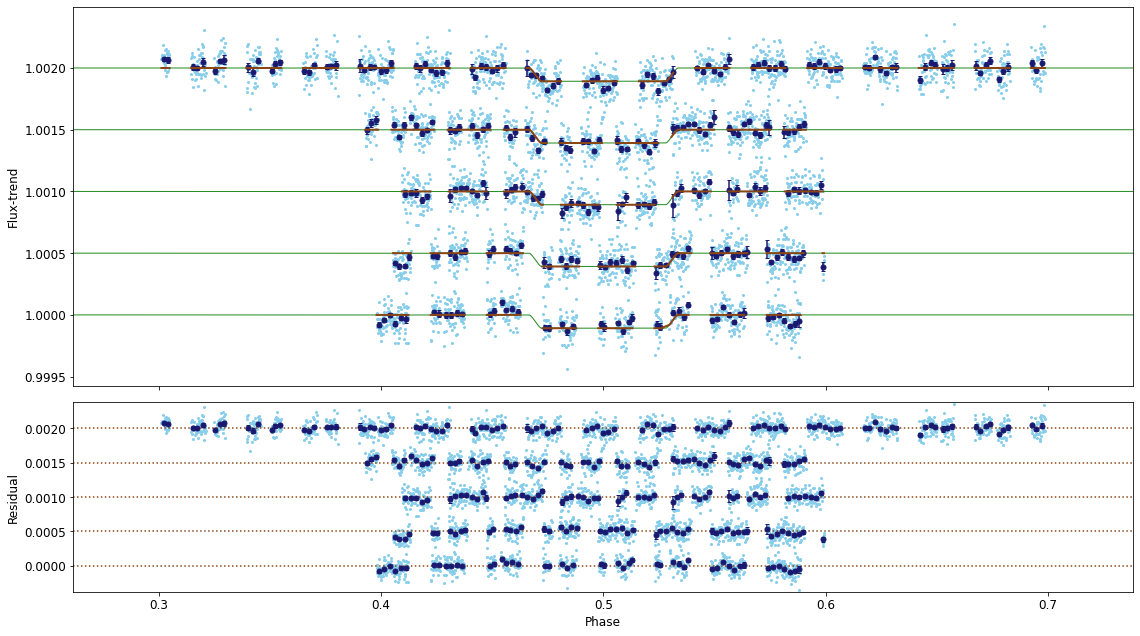

In [6]:
M.plot_fit(binwidth=0.0025, data_offset=0.0005, res_offset=0.0005, detrend=True, figsize=(16,9));

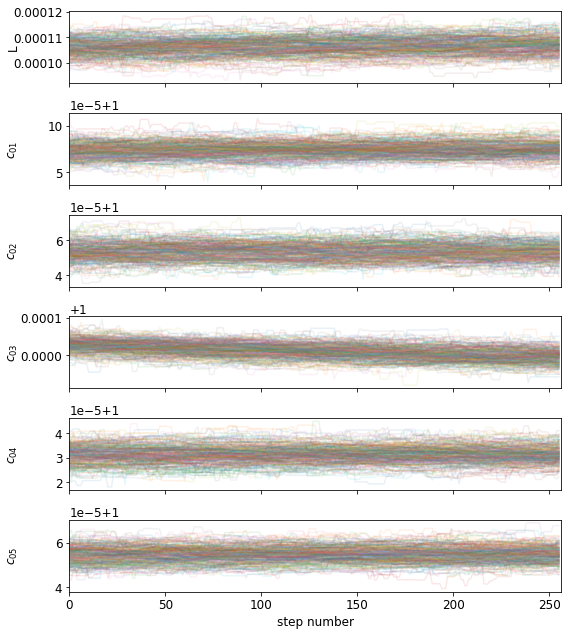

In [7]:
M.trail_plot();

## Trend of Roll-Anlge with time

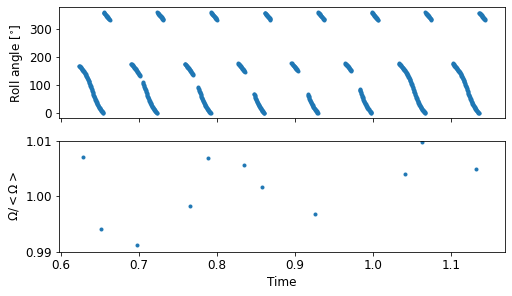

In [8]:
fig,ax = plt.subplots(figsize=(8,4.5),nrows=2,sharex=True)
t = M.datasets[0].lc['time']
t0 = np.floor(t[0])
roll_angle = M.datasets[0].lc['roll_angle']
ax[0].plot(t-t0,roll_angle,'.')
ax[0].set_ylabel('Roll angle [$^{\circ}$]')
drdt = np.gradient(roll_angle)
Omega = np.nanmedian(drdt)
ax[1].plot(t-t0,drdt/Omega,'.')
ax[1].set_ylim(0.99,1.01)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('$\Omega/<\Omega>$');

Wow! The variations can be indeed high! We can remove this correlations as follows:

 - We can either ignore it (only if trends are not large)
 - We can increase nroll (upto which harmonics of roll angle we want to include in decorrelation)
 - Or we can remove the prior decorrelation first and then fit for it (using `unwrap=True`).

In [9]:
result = M.fit_eclipse(unroll=True, nroll=1, unwrap=True, P=2.72403380, D=0.00499886, a_c=a_c, L=(50e-6,150e-6),
                       W=ufloat(0.06620089, 8.6417e-05), b=ufloat(0.42977891, 0.01901114),
                       extra_priors={
                           'T_0':ufloat(1970.12401, 8.3063e-04),
                            'h_1':ufloat(0.787, 0.100),
                            'logrhoprior':ufloat(-0.89, 0.33)},
                       burn=512, steps=256, nwalkers=256)

Running burn-in ..


  6%|▌         | 30/512 [00:33<08:19,  1.04s/it]/home/jayshil/anaconda3/lib/python3.8/site-packages/asteval/asteval.py:750: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **keywords)
  6%|▋         | 33/512 [00:36<08:04,  1.01s/it]/home/jayshil/anaconda3/lib/python3.8/site-packages/asteval/asteval.py:750: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **keywords)
  7%|▋         | 34/512 [00:37<07:52,  1.01it/s]/home/jayshil/anaconda3/lib/python3.8/site-packages/asteval/asteval.py:750: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **keywords)
  7%|▋         | 36/512 [00:39<07:41,  1.03it/s]/home/jayshil/anaconda3/lib/python3.8/site-packages/asteval/asteval.py:750: RuntimeWarning: invalid value encountered in sqrt
  return func(*args, **keywords)
  7%|▋         | 37/512 [00:40<07:36,  1.04it/s]/home/jayshil/anaconda3/lib/python3.8/site-packages/asteval/asteval.py:750: RuntimeWarning: invalid value encountered in sqr

Running sampler ..



100%|██████████| 256/256 [06:16<00:00,  1.47s/it]


In [10]:
print(M.fit_report(min_correl=0.8))

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 227439
    # data points      = 4866
    # variables        = 22
    chi-square         = 7396.91603
    reduced chi-square = 1.52702643
    Akaike info crit   = -76450.1628
    Bayesian info crit = -76307.3822
    RMS residual       = 100.4 ppm
[[Variables]]
    D:               0.00499886 (fixed)
    W:               0.06620934 +/- 8.4948e-05 (0.13%) (init = 0.06620089)
    b:               0.43181411 +/- 0.01888037 (4.37%) (init = 0.4297789)
    P:               2.724034 (fixed)
    T_0:             1970.12466 +/- 4.0869e-04 (0.00%) (init = 1970.127)
    f_c:             0 (fixed)
    f_s:             0 (fixed)
    L:               1.0879e-04 +/- 3.0640e-06 (2.82%) (init = 0.0001)
    a_c:             0.0002918369 (fixed)
    k:               0.07070262 == 'sqrt(D)'
    aR:              4.71034856 == 'sqrt((1+k)**2-b**2)/W/pi'
    sini:            0.99578912 == 'sqrt(1 - (b/aR)**2)'
    logrho:         -0.723

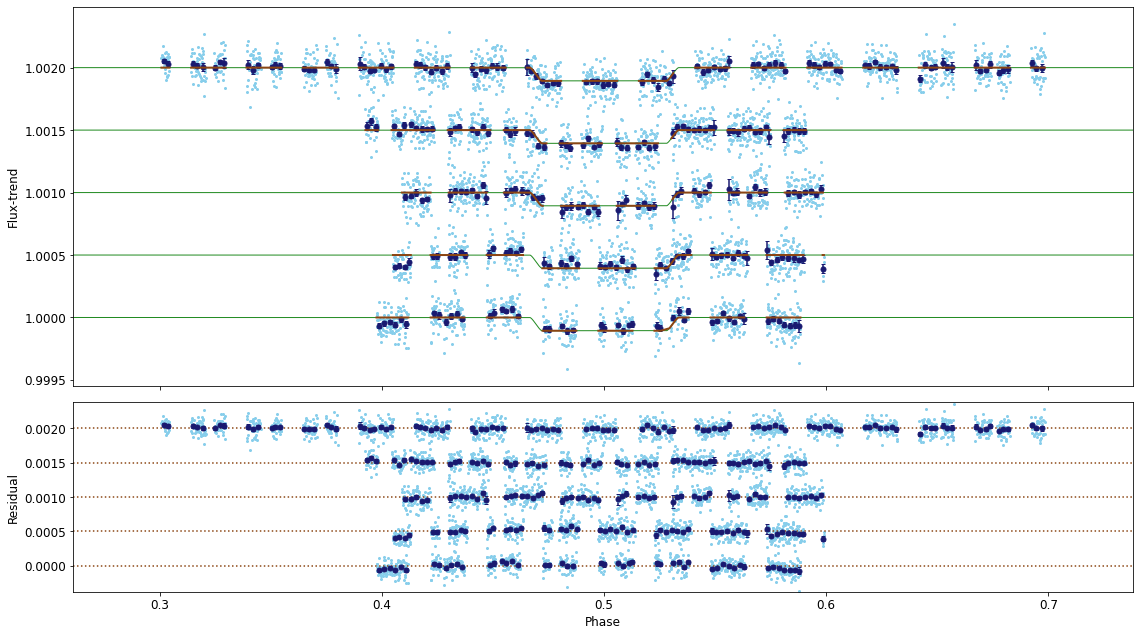

In [11]:
M.plot_fit(binwidth=0.0025, data_offset=0.0005, res_offset=0.0005, detrend=True, figsize=(16,9));

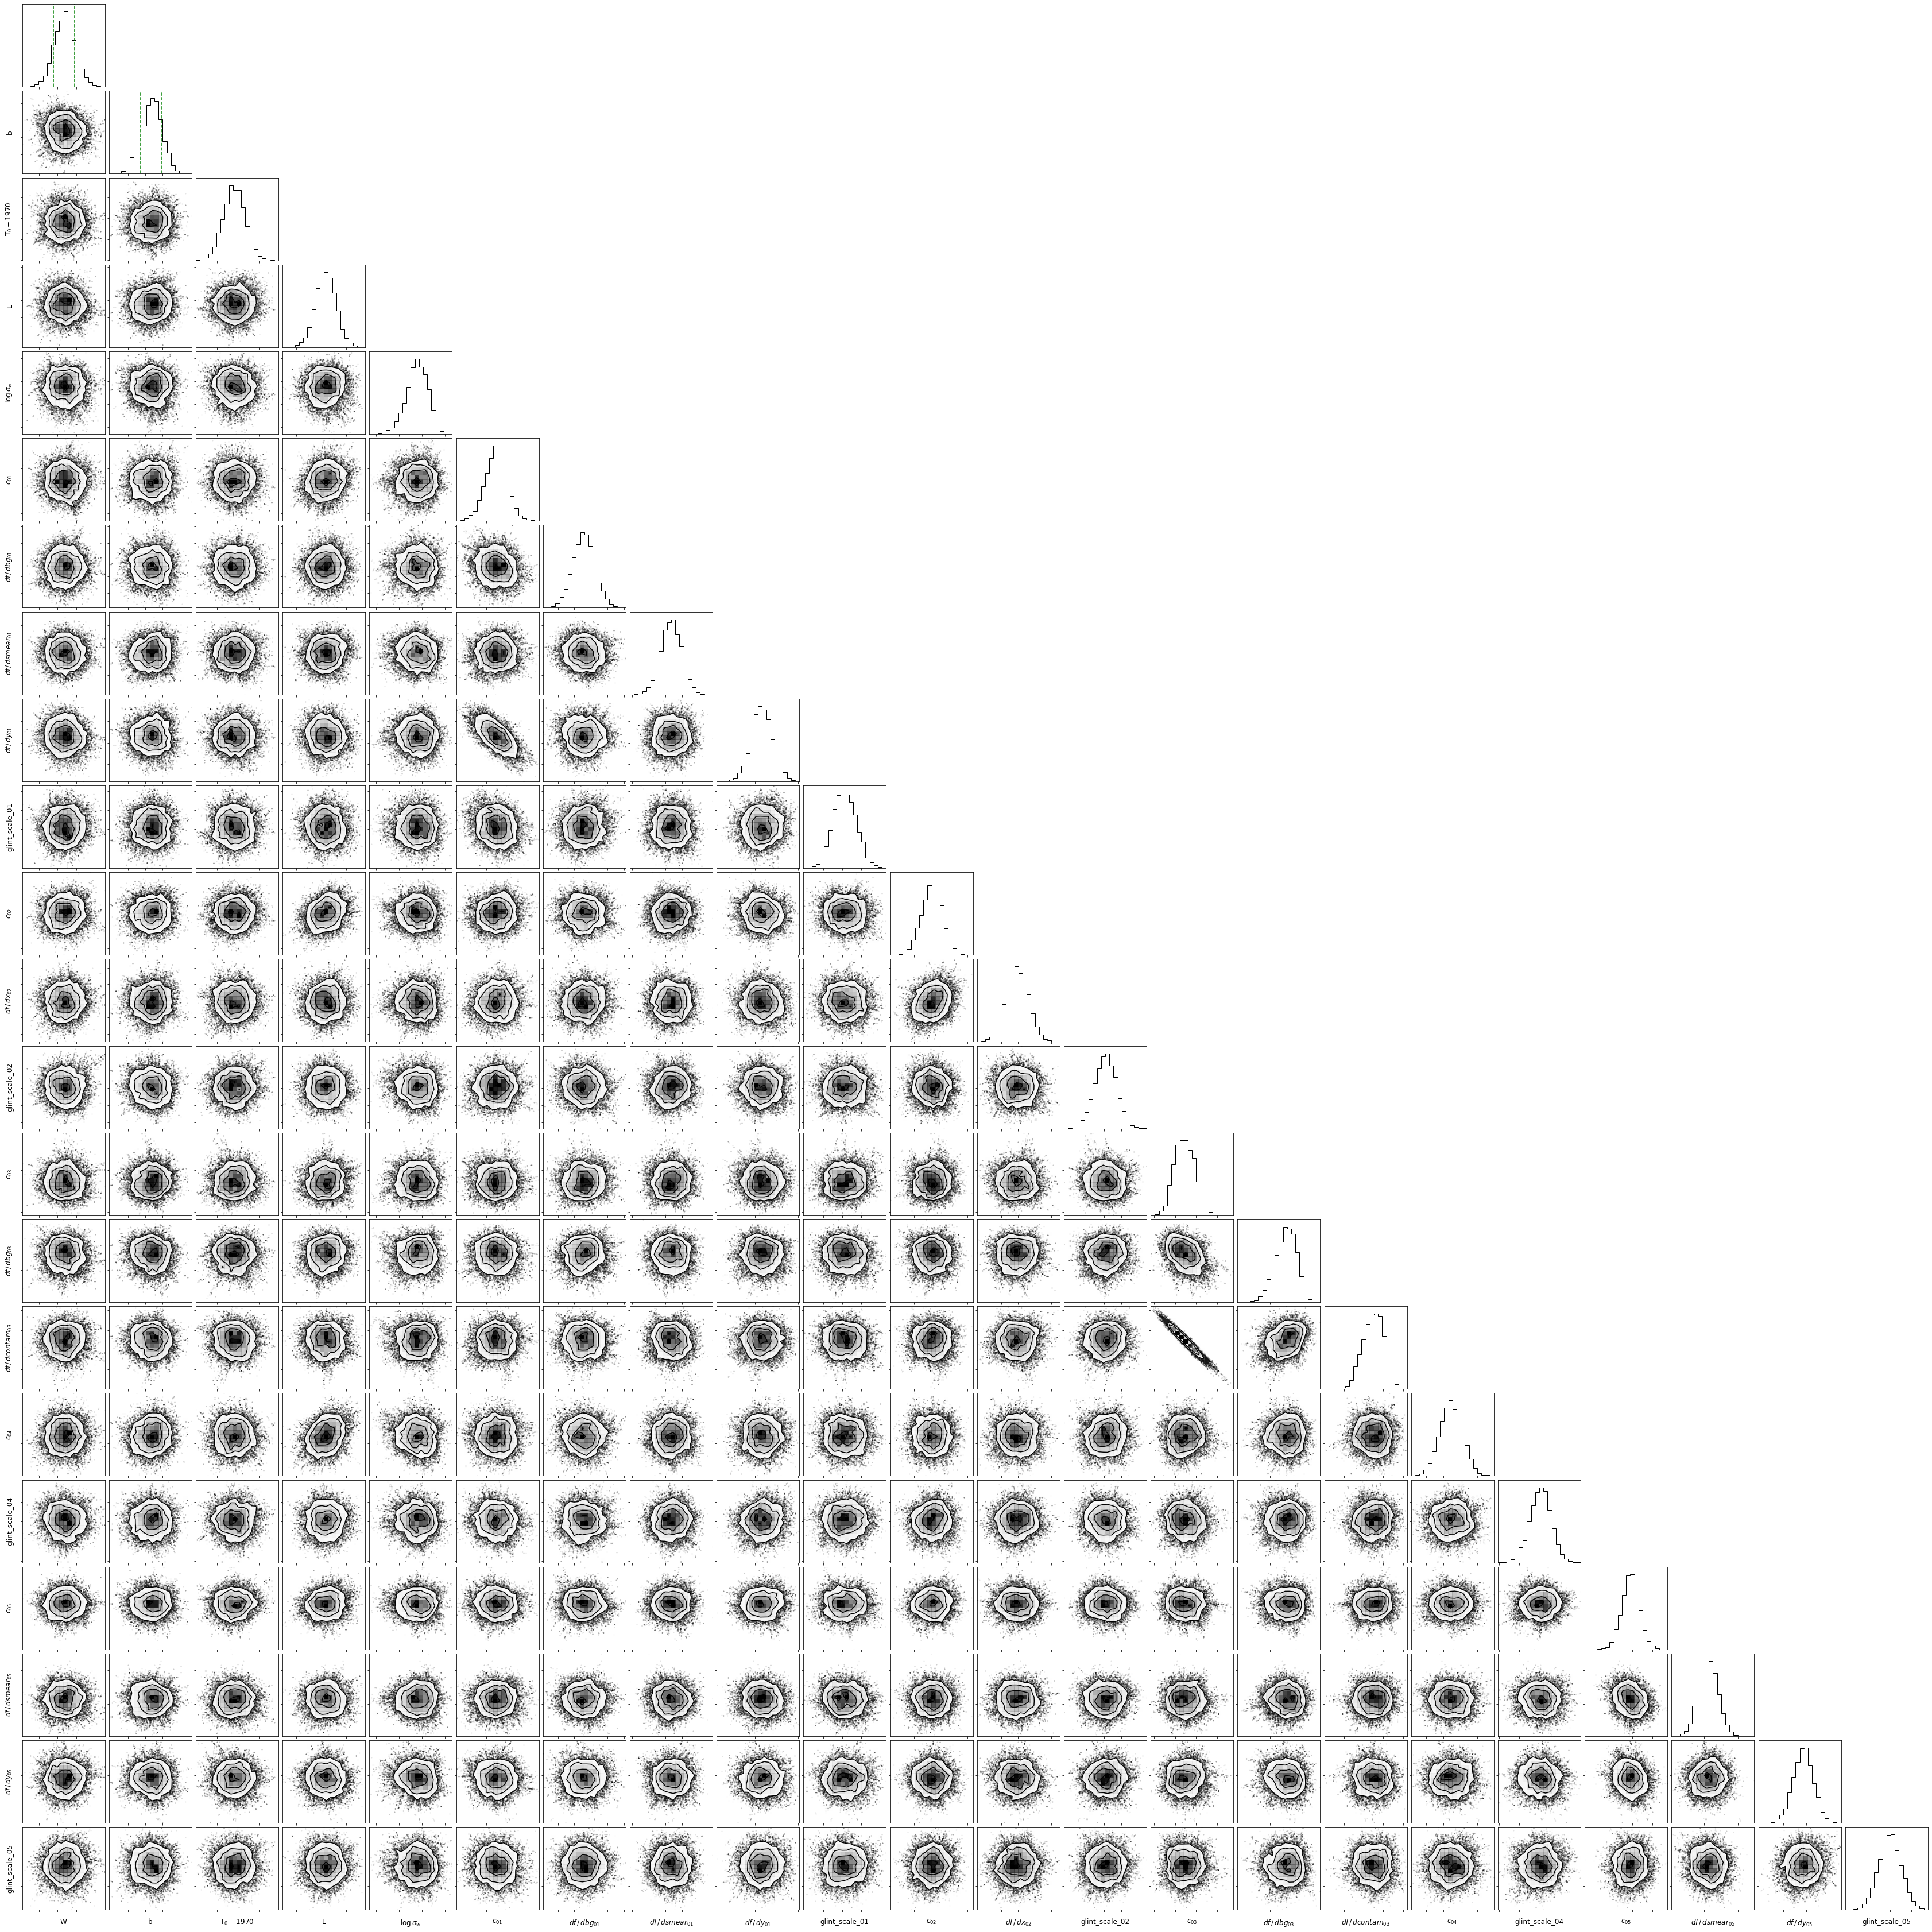

In [12]:
M.corner_plot(plotkeys='all');

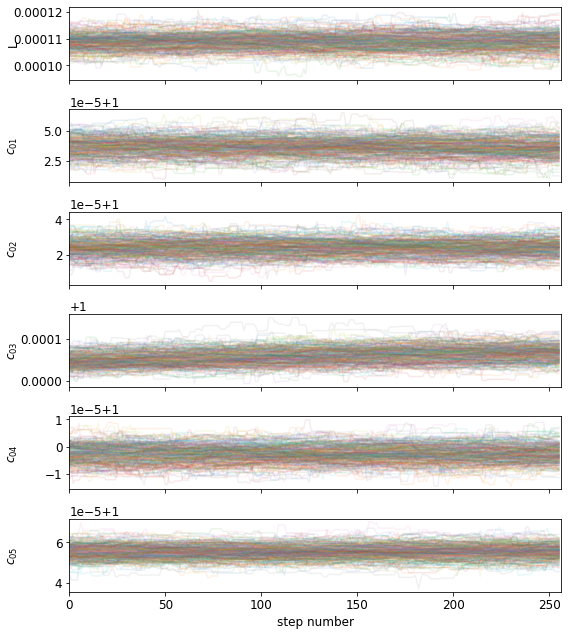

In [13]:
M.trail_plot();